In [104]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import re
from config import *

# Sklearn
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, HDBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from kneed import KneeLocator
from scipy import stats


from scipy.cluster.hierarchy import dendrogram, linkage

import umap

# Visual
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from itertools import permutations 
from tqdm import tqdm

In [124]:

def remove_low_variance_features(X, threshold=0.01):
    """
    Remove features with variance below a specified threshold.
    
    Parameters:
    -----------
    X : DataFrame
        Feature matrix
    threshold : float, optional (default=0.01)
        Variance threshold below which features will be removed
        
    Returns:
    --------
    X_reduced : DataFrame
        Feature matrix with low variance features removed
    """
    # Apply variance threshold
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X)

    # Get selected feature names
    selected_feature_names = X.columns[selector.get_support()]

    # Create reduced DataFrame
    X_reduced = X[selected_feature_names]

    logging.info(f"Kept {X_reduced.shape[1]} features out of {X.shape[1]}")
    
    return X_reduced

def remove_multicollineraity(X, y, feature_corr_threshold=0.85):
    """
    Remove highly correlated features while prioritizing features with higher correlation to target.
    
    Parameters:
    -----------
    X : DataFrame
        Feature matrix
    y : Series or DataFrame
        Target variable
    feature_corr_threshold : float, optional (default=0.85)
        Threshold above which features are considered highly correlated
        
    Returns:
    --------
    X_reduced : DataFrame
        Feature matrix with highly correlated features removed
    """
    # Covert y to series
    y = y.iloc[:,0]
    
    # Calculate feature-feature correlation matrix
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Calculate feature-target correlation
    corr_with_y = pd.DataFrame(X.corrwith(y).abs(), columns=["Corr"])
    
    # Add variance as secondary criterion for tie-breaking
    corr_with_y["Variance"] = X.var().values
    
    # Sort by correlation with target (primary) and variance (secondary)
    corr_with_y_sorted = corr_with_y.sort_values(
        by=["Corr", "Variance"], ascending=[False, False]
    )

    # Remove highly correlated features
    to_drop = set()
    for column in corr_with_y_sorted.index:
        if column in to_drop:
            continue
        
        # Find highly correlated features
        corr_features = upper.index[upper[column] > feature_corr_threshold].tolist()
        
        for corr_feature in corr_features:
            if corr_feature not in to_drop:
                to_drop.add(corr_feature)

    X_reduced = X.drop(columns=list(to_drop))

    logging.info(f"Removed {len(to_drop)} highly correlated features: {to_drop}")
    
    return X_reduced

def remove_outliers(X, method:str = "MAD", threshold:float = 3.0):
    if method == 'MAD':
        for col in X.columns:
            data = X[col]
            median = np.nanmedian(data)
            abs_diff = np.abs(data - median)
            mad = np.nanmedian(abs_diff)

            if mad == 0 or np.isnan(mad):
                continue

            outlier_mask = (np.abs(data - median)) > (threshold * mad)
            X.loc[outlier_mask, col] = np.nan
        return X
    else:
        return X
    

In [126]:
all_features_with_info_raw = (pd.read_parquet(FEATURES_DIR / "all_features.pq"))
all_features_with_info_raw = all_features_with_info_raw[~(all_features_with_info_raw.isna().sum(axis=1) == all_features_with_info_raw.shape[1]-2)]


y = pd.DataFrame(all_features_with_info_raw["y"], columns=["y"])


all_features_with_info = (all_features_with_info_raw
        .pipe(remove_low_variance_features)
        .pipe(remove_multicollineraity, y)
        .pipe(remove_outliers, 10.0)
)



X = (all_features_with_info.query("y==1")
 .drop(["participant_id", "y"], axis=1)
 .dropna()
)

X_stdz = pd.DataFrame(StandardScaler().fit_transform(X.values), columns=X.columns)

2025-05-09 14:52:26,884 - INFO - 1152532481.remove_low_variance_features:27 - Kept 493 features out of 520
2025-05-09 14:52:26,975 - INFO - 1152532481.remove_multicollineraity:82 - Removed 174 highly correlated features: {'SHAPES_duration_mean_fix', 'REACTION_total_acceleration_magnitude_std', 'FIXATIONS_Var_total', 'EVIL_BASTARD_avg_pupil_size_median_fix', 'SHAPES_amplitude_mean_sacc', 'SMOOTH_PURSUITS_avg_pupil_size_min_fix', 'REACTION_peak_velocity_mean_sacc', 'EVIL_BASTARD_fixations_per_second_min', 'KING_DEVICK_avg_pupil_size_mean_fix', 'SHAPES_fixations_per_second_max', 'KING_DEVICK_duration_max_fix', 'FITTS_LAW_fixations_per_second_median', 'FITTS_LAW_avg_pupil_size_min_fix', 'ANTI_SACCADE_avg_pupil_size_min_fix', 'KING_DEVICK_amplitude_mean_sacc', 'KING_DEVICK_avg_pupil_size_median_fix', 'FIXATIONS_total_acceleration_magnitude_median', 'EVIL_BASTARD_distance_to_fixpoint_x_mean', 'ANTI_SACCADE_peak_velocity_mean_sacc', 'SMOOTH_PURSUITS_avg_pupil_size_mean_fix', 'ANTI_SACCADE_tot

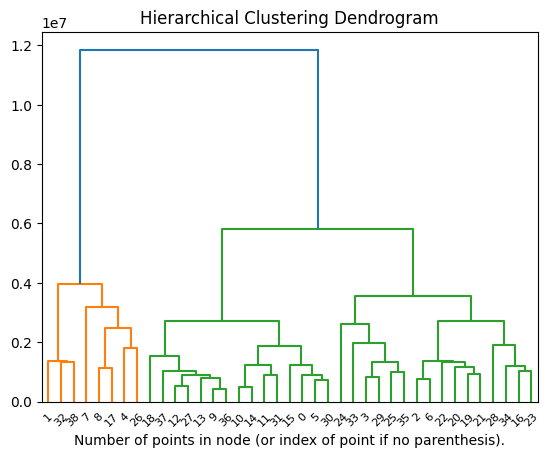

In [127]:



def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0,n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode = 'level', p=100)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [129]:
n_clusters_to_try = range(2,15)

clustering_results = {
    "n_clusters": [],
    "silhouette_scores": [],
    "labels": []
}

for n_cluster in n_clusters_to_try:
    model = AgglomerativeClustering(n_clusters=n_cluster)
    model.fit(X)
    labels = model.labels_
    sil_score = silhouette_score(X, labels)
    clustering_results["silhouette_scores"].append(sil_score)
    clustering_results["n_clusters"].append(n_cluster)
    clustering_results["labels"].append(model.labels_)

clustering_results = pd.DataFrame(clustering_results)

In [131]:
feature_importance_results = {
    'best_params': [],
    'n_clusters': [],
    'feature_importances': [],
    'silhouette_scores': []
}

for i, row in tqdm(clustering_results.iterrows(), total=clustering_results.shape[0]):
    n_cluster = row["n_clusters"]
    silhoette_scores = row["silhouette_scores"]
    y = row["labels"]
    # Initialize results

    feature_importances = pd.DataFrame(
        np.zeros(X.shape[1]), 
        columns=["Importance"], 
        index=X.columns)

    # Hyperparameters for GridSearch
    parameters = {
        'max_depth': [None, 3, 5, 7, 9, 11],
        'n_estimators': [20, 30, 40, 50, 70, 100],
        'max_features': ['sqrt', 'log2', None]
    }


    # Find best clf
    grid_search = GridSearchCV(
        RandomForestClassifier(n_jobs=-1, random_state=42), 
        parameters, 
        cv=2,
        verbose=1, 
        n_jobs=-1)

    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    importances = best_model.feature_importances_
    best_params = grid_search.best_params_

    # update importances
    feature_importances.loc[X.columns, "Importance"] += importances
    
    feature_importance_results["best_params"].append(best_params)
    feature_importance_results["feature_importances"].append(feature_importances)
    feature_importance_results['n_clusters'].append(n_cluster)
    feature_importance_results["silhouette_scores"].append(silhoette_scores)



  0%|          | 0/13 [00:00<?, ?it/s]

Fitting 2 folds for each of 108 candidates, totalling 216 fits


  8%|▊         | 1/13 [00:03<00:42,  3.51s/it]

Fitting 2 folds for each of 108 candidates, totalling 216 fits


 15%|█▌        | 2/13 [00:05<00:26,  2.44s/it]

Fitting 2 folds for each of 108 candidates, totalling 216 fits


 23%|██▎       | 3/13 [00:06<00:21,  2.10s/it]

Fitting 2 folds for each of 108 candidates, totalling 216 fits


 31%|███       | 4/13 [00:08<00:17,  1.95s/it]/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Fitting 2 folds for each of 108 candidates, totalling 216 fits


 38%|███▊      | 5/13 [00:10<00:14,  1.87s/it]/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Fitting 2 folds for each of 108 candidates, totalling 216 fits


 46%|████▌     | 6/13 [00:12<00:12,  1.81s/it]/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Fitting 2 folds for each of 108 candidates, totalling 216 fits


 54%|█████▍    | 7/13 [00:13<00:10,  1.78s/it]/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Fitting 2 folds for each of 108 candidates, totalling 216 fits


 62%|██████▏   | 8/13 [00:15<00:08,  1.78s/it]/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Fitting 2 folds for each of 108 candidates, totalling 216 fits


 69%|██████▉   | 9/13 [00:17<00:07,  1.78s/it]/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Fitting 2 folds for each of 108 candidates, totalling 216 fits


 77%|███████▋  | 10/13 [00:19<00:05,  1.79s/it]/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Fitting 2 folds for each of 108 candidates, totalling 216 fits


 85%|████████▍ | 11/13 [00:20<00:03,  1.79s/it]/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Fitting 2 folds for each of 108 candidates, totalling 216 fits


 92%|█████████▏| 12/13 [00:22<00:01,  1.83s/it]/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Fitting 2 folds for each of 108 candidates, totalling 216 fits


100%|██████████| 13/13 [00:24<00:00,  1.91s/it]


In [ ]:




sorted_feature_importance = (feature_importances
 .sort_values("Importance", ascending=False)
 .reset_index()
)

importance_values = sorted_feature_importance["Importance"].values
feature_ranks = np.arange(len(importance_values))

# Find knee
knee = KneeLocator(
    feature_ranks, 
    importance_values, 
    curve='convex', 
    direction='decreasing'
)
knee_point = knee.knee

if knee_point is not None:
    logging.info(f"Knee detected at feature rank {knee_point}")
else:
    logging.warning("Knee point is not detected")
    knee_point = len(sorted_feature_importance) - 1

# Select features above knee
selected_features_exp = sorted_feature_importance.iloc[:knee_point+1]
logging.info(f"Automatically selected {selected_features_exp.shape[0]} features")

selected_features_exp


2025-05-09 14:14:07,298 - INFO - 908516869.<module>:19 - Knee detected at feature rank 23
2025-05-09 14:14:07,298 - INFO - 908516869.<module>:26 - Automatically selected 24 features


,index,Importance
0,EVIL_BASTARD_distance_to_fixpoint_x_max,0.100487
1,SMOOTH_PURSUITS_distance_to_fixpoint_y_std,0.085703
2,EVIL_BASTARD_distance_to_fixpoint_max,0.085613
3,SMOOTH_PURSUITS_duration_mean_sacc,0.077913
4,SMOOTH_PURSUITS_distance_to_fixpoint_x_max,0.067887
5,EVIL_BASTARD_x_acceleration_max,0.062481
6,SHAPES_distance_to_fixpoint_max,0.047659
7,SMOOTH_PURSUITS_distance_to_fixpoint_max,0.046108
8,FITTS_LAW_total_acceleration_magnitude_max,0.040524
9,EVIL_BASTARD_total_acceleration_magnitude_max,0.039809


<Axes: >

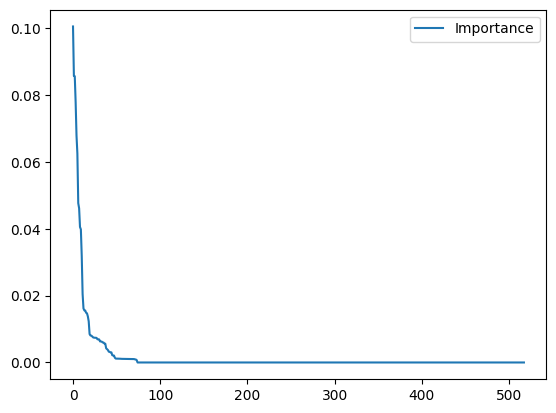

In [21]:
sorted_feature_importance.plot()